In [1]:

import argparse
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import abcclassify.abcclassify as abcc
import csv
import os.path
from sklearn import tree


In [2]:

participant = abcc.videotracking(framerange=(10530, 15611))
participant.addtrackingdata("/home/zzalsdme/IDInteraction/paper/results/OpenFace/P01_front.openface")
groundtruth = abcc.loadExternalGroundTruth("/home/zzalsdme/IDInteraction/paper/results/Groundtruth/P01_attention.csv", participant)
# All the potential training frames
trainingframes = participant.frames
np.random.shuffle(trainingframes)

cvfolds = 5


Loading tracking data from: /home/zzalsdme/IDInteraction/paper/results/OpenFace/P01_front.openface
OpenFace input detected


We want to explore different approaches to training the classifier.  We've already looked at sequential and random, and shown that random classification leads to much better performance.  

Rob suggested looking at areas that had poor performance, and focussing on these.  If we've got ground truth we *know* where has poor performance. Normally though we'll need to use cross validation to estimate the performance of the classifier


We want a window size such that the cross-validation scores are resonably stable.



In [3]:
maxsd = 0.05
batchsize = 30
participant.setClassificationMethod("random")
for batch in range(0,10):
    for f in range(0, batchsize):
        thisframe = trainingframes.pop()
        participant.setClassification(thisframe, \
                                      groundtruth.loc[thisframe]["state"], \
                                      testunset = True )
    vtc = abcc.videotrackingclassifier(participant)
    xvalscore = vtc.getCrossValidatedScore(cv=cvfolds)
    print str(vtc.vto.numClassifiedFrames()) + " "+ str(xvalscore.mean()) + " " + str(xvalscore.std())
      
    
    



30 0.866666666667 0.124721912892
60 0.933333333333 0.0623609564462
90 0.8 0.114395890455
120 0.891666666667 0.0333333333333
150 0.86 0.0388730126323
180 0.877777777778 0.0484322104838
210 0.885714285714 0.0178174161275
240 0.8875 0.0386400770646
270 0.87037037037 0.0309874083902
300 0.9 0.0394405318873


We see that accuracy tends to improve, and varition between x-val folds decreases.
Now we define a moving window function, to extract specific subsets of the data.  We pull out subsets with a constant number of frames (TODO ones at end???), regardless of how many frames have been classified within them.  



In [4]:
windowsize = 1000 # Number of (total - classified and unclassified) frames in each window
advancesize = 250  # The amount to advance each window by
# overlap between adjacent windows will be windowsize - advancesize

firstframe = min(participant.frames)
lastframe = max(participant.frames)

windowstarts = range(firstframe, lastframe - windowsize, advancesize)

means=[]
stds = []
for fr in windowstarts:
    thispart = participant.split((fr, fr + windowsize))
    try: 
        thispartvtc = abcc.videotrackingclassifier(thispart)
        xvalscore = vtc.getCrossValidatedScore(cv = cvfolds)
    except ValueError:
        xvalscore = np.array([np.NaN])
    means.append(xvalscore.mean())
    stds.append(xvalscore.std())

    
results = pd.DataFrame.from_items([("startframe", windowstarts),
                                  ("mean", means),
                                  ("std", stds)])


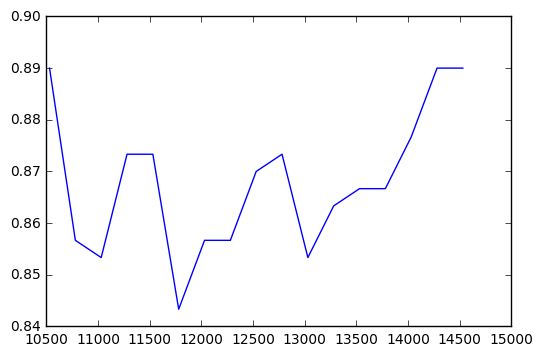

In [7]:
plt.plot(results["startframe"], results["mean"])

plt.show()


In [14]:
# Find the minimum startframe
minstartframe = results["startframe"].iloc[results["mean"].argmin()]

subpart = participant.split((minstartframe, minstartframe + windowsize))

